In [137]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import Ridge
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

In [138]:
sample = pd.read_csv('../data/sample4.csv')

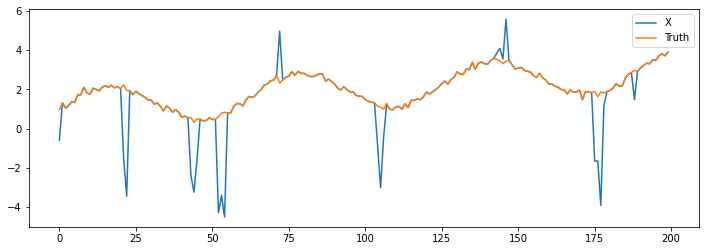

In [139]:
plt.figure(figsize=(12, 4))
sample[:200].plot(ax=plt.gca())
plt.show()

# Predicted-real values difference

In [192]:
X = sample.X.values
X_clean = X.copy()
alpha = 0.2
fit = SimpleExpSmoothing(X_clean).fit(alpha)
X_smooth = fit.predict(0, X_clean.shape[0] - 1)
fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
X_smooth = fit.predict(0, X_clean.shape[0] - 1)[::-1]
        
X_diff = X - X_smooth
X_diff = (X_diff / np.linalg.norm(X_diff)).reshape(-1, 1)

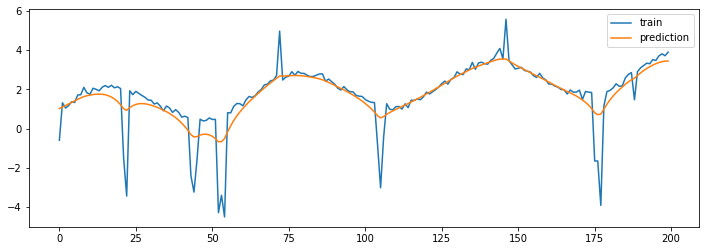

In [193]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X.values[:200], label='train')
plt.plot(np.concatenate([X_smooth, Y_pred])[:200], label='prediction')
plt.legend()
plt.show()

# Anomaly detection (Elliptic Envelope)

In [194]:
outliers_fraction = 0.2
model = EllipticEnvelope(contamination=outliers_fraction)
labels = model.fit(X_diff).predict(X_diff)

In [195]:
X_clean[labels == -1] = None
X_clean = pd.Series(X_clean).interpolate().values
X_clean = pd.Series(X_clean).fillna(method='ffill').values
X_clean = pd.Series(X_clean).fillna(method='bfill').values

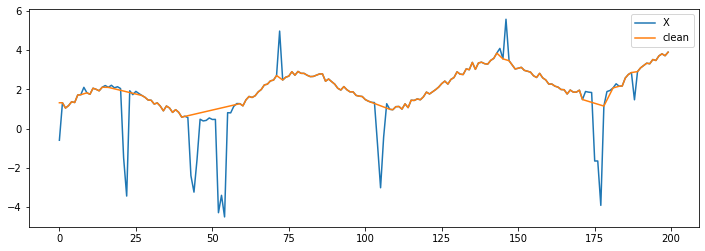

In [196]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:200], label='X')
plt.plot(X_clean[:200], label='clean')
plt.legend()
plt.show()

In [197]:
mean_squared_error(sample.Truth, X_clean, squared=False)

0.16836974985276992

In [221]:
def exp_smooth_anomaly(X, model):
    
    X_clean = X.copy()
    
    alpha = 0.2
    fit = SimpleExpSmoothing(X_clean).fit(alpha)
    X_smooth = fit.predict(0, X_clean.shape[0] - 1)
    fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
    X_smooth = fit.predict(0, X_clean.shape[0] - 1)[::-1]

    X_diff = X - X_smooth
    X_diff = (X_diff / np.linalg.norm(X_diff)).reshape(-1, 1)

    if type(LocalOutlierFactor()).__name__ == 'LocalOutlierFactor':
        labels = model.fit_predict(X_diff)
    else:
        labels = model.fit(X_diff).predict(X_diff)
        
    X_clean[labels == -1] = None
    X_clean = pd.Series(X_clean).interpolate().values
    X_clean = pd.Series(X_clean).fillna(method='ffill').values
    X_clean = pd.Series(X_clean).fillna(method='bfill').values
    
    return X_clean

In [222]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path, model):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = exp_smooth_anomaly(X, model)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [202]:
outliers_fraction = 0.2
eenvelope_report = run_tests('../data/', EllipticEnvelope(contamination=outliers_fraction))
eenvelope_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.14520242906358088
File:  ../data/sample2.csv
RMSE:  0.10645676902999769
File:  ../data/sample3.csv
RMSE:  0.17436916947832076
File:  ../data/sample4.csv
RMSE:  0.16836974985276992
File:  ../data/sample5.csv
RMSE:  0.14594260101334422
File:  ../data/sample6.csv
RMSE:  3.815374830859415
File:  ../data/sample7.csv
RMSE:  9.361486599322017
File:  ../data/sample8.csv
RMSE:  0.7671358028289681
File:  ../data/sample9.csv
RMSE:  114.53382066407238


Sample        RMSE
0  ../data/sample1.csv    0.145202
1  ../data/sample2.csv    0.106457
2  ../data/sample3.csv    0.174369
3  ../data/sample4.csv    0.168370
4  ../data/sample5.csv    0.145943
5  ../data/sample6.csv    3.815375
6  ../data/sample7.csv    9.361487
7  ../data/sample8.csv    0.767136
8  ../data/sample9.csv  114.533821

In [210]:
outliers_fraction = 0.2
svm_report = run_tests(
    '../data/', 
    svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
)
svm_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1485151119316476
File:  ../data/sample2.csv
RMSE:  0.11963375124269544
File:  ../data/sample3.csv
RMSE:  0.17522880673872424
File:  ../data/sample4.csv
RMSE:  0.16009016721570285
File:  ../data/sample5.csv
RMSE:  0.1469378217090505
File:  ../data/sample6.csv
RMSE:  3.8186243879813135
File:  ../data/sample7.csv
RMSE:  9.34005248035016
File:  ../data/sample8.csv
RMSE:  0.8225944168932499
File:  ../data/sample9.csv
RMSE:  114.32827492759007


Sample        RMSE
0  ../data/sample1.csv    0.148515
1  ../data/sample2.csv    0.119634
2  ../data/sample3.csv    0.175229
3  ../data/sample4.csv    0.160090
4  ../data/sample5.csv    0.146938
5  ../data/sample6.csv    3.818624
6  ../data/sample7.csv    9.340052
7  ../data/sample8.csv    0.822594
8  ../data/sample9.csv  114.328275

In [211]:
outliers_fraction = 0.2
iforest_report = run_tests(
    '../data/', 
    IsolationForest(contamination=outliers_fraction, random_state=0)
)
iforest_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1430839681101621
File:  ../data/sample2.csv
RMSE:  0.12272254339706144
File:  ../data/sample3.csv
RMSE:  0.17405648073224247
File:  ../data/sample4.csv
RMSE:  0.16949088462006429
File:  ../data/sample5.csv
RMSE:  0.14537269940683928
File:  ../data/sample6.csv
RMSE:  3.8082118819710775
File:  ../data/sample7.csv
RMSE:  9.350480766113439
File:  ../data/sample8.csv
RMSE:  0.7655273899232079
File:  ../data/sample9.csv
RMSE:  114.30537384951218


Sample        RMSE
0  ../data/sample1.csv    0.143084
1  ../data/sample2.csv    0.122723
2  ../data/sample3.csv    0.174056
3  ../data/sample4.csv    0.169491
4  ../data/sample5.csv    0.145373
5  ../data/sample6.csv    3.808212
6  ../data/sample7.csv    9.350481
7  ../data/sample8.csv    0.765527
8  ../data/sample9.csv  114.305374

In [234]:
outliers_fraction = 0.2
loutlier_report = run_tests(
    '../data/', 
    LocalOutlierFactor(n_neighbors=400, contamination=outliers_fraction)
)
loutlier_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.13690427981049225
File:  ../data/sample2.csv
RMSE:  0.10470051524133295
File:  ../data/sample3.csv
RMSE:  0.17452371140970183
File:  ../data/sample4.csv
RMSE:  0.16839261048716597
File:  ../data/sample5.csv
RMSE:  0.14477767907523062
File:  ../data/sample6.csv
RMSE:  3.944387205146725
File:  ../data/sample7.csv
RMSE:  9.346453870957973
File:  ../data/sample8.csv
RMSE:  0.6985313484111728
File:  ../data/sample9.csv
RMSE:  108.64244902441953


Sample        RMSE
0  ../data/sample1.csv    0.136904
1  ../data/sample2.csv    0.104701
2  ../data/sample3.csv    0.174524
3  ../data/sample4.csv    0.168393
4  ../data/sample5.csv    0.144778
5  ../data/sample6.csv    3.944387
6  ../data/sample7.csv    9.346454
7  ../data/sample8.csv    0.698531
8  ../data/sample9.csv  108.642449

In [235]:
board = pd.DataFrame(columns=['Data preparation', 'Model'] + ['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Exponential smoothing', 'Elliptic envelope'] + list(eenvelope_report['RMSE'].values)
board.loc[len(board)] = ['Exponential smoothing', 'SVM'] + list(svm_report['RMSE'].values)
board.loc[len(board)] = ['Exponential smoothing', 'Isolation forest'] + list(iforest_report['RMSE'].values)
board.loc[len(board)] = ['Exponential smoothing', 'Local outlier factor'] + list(loutlier_report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3  \
Data preparation      Model                                                
Exponential smoothing Elliptic envelope     0.145202  0.106457  0.174369   
                      SVM                   0.148515  0.119634  0.175229   
                      Isolation forest      0.143084  0.122723  0.174056   
                      Local outlier factor  0.136904  0.104701  0.174524   

                                             sample4   sample5   sample6  \
Data preparation      Model                                                
Exponential smoothing Elliptic envelope     0.168370  0.145943  3.815375   
                      SVM                   0.160090  0.146938  3.818624   
                      Isolation forest      0.169491  0.145373  3.808212   
                      Local outlier factor  0.168393  0.144778  3.944387   

                                             sample7   sample8     sample9  
Data preparation      Model                                                 
Exponential smoothing Elliptic envelope     9.361487  0.767136  114.533821  
                      SVM                   9.340052  0.822594  114.328275  
                      Isolation forest      9.350481  0.765527  114.305374  
                      Local outlier factor  9.346454  0.698531  108.642449

In [236]:
board.to_csv('../results/anomaly_detection_models.csv')